In [1]:
# import the library
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
from google.colab import drive
drive.mount('/content/drive')

dataroot = "/content/drive/MyDrive/ecs171_data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

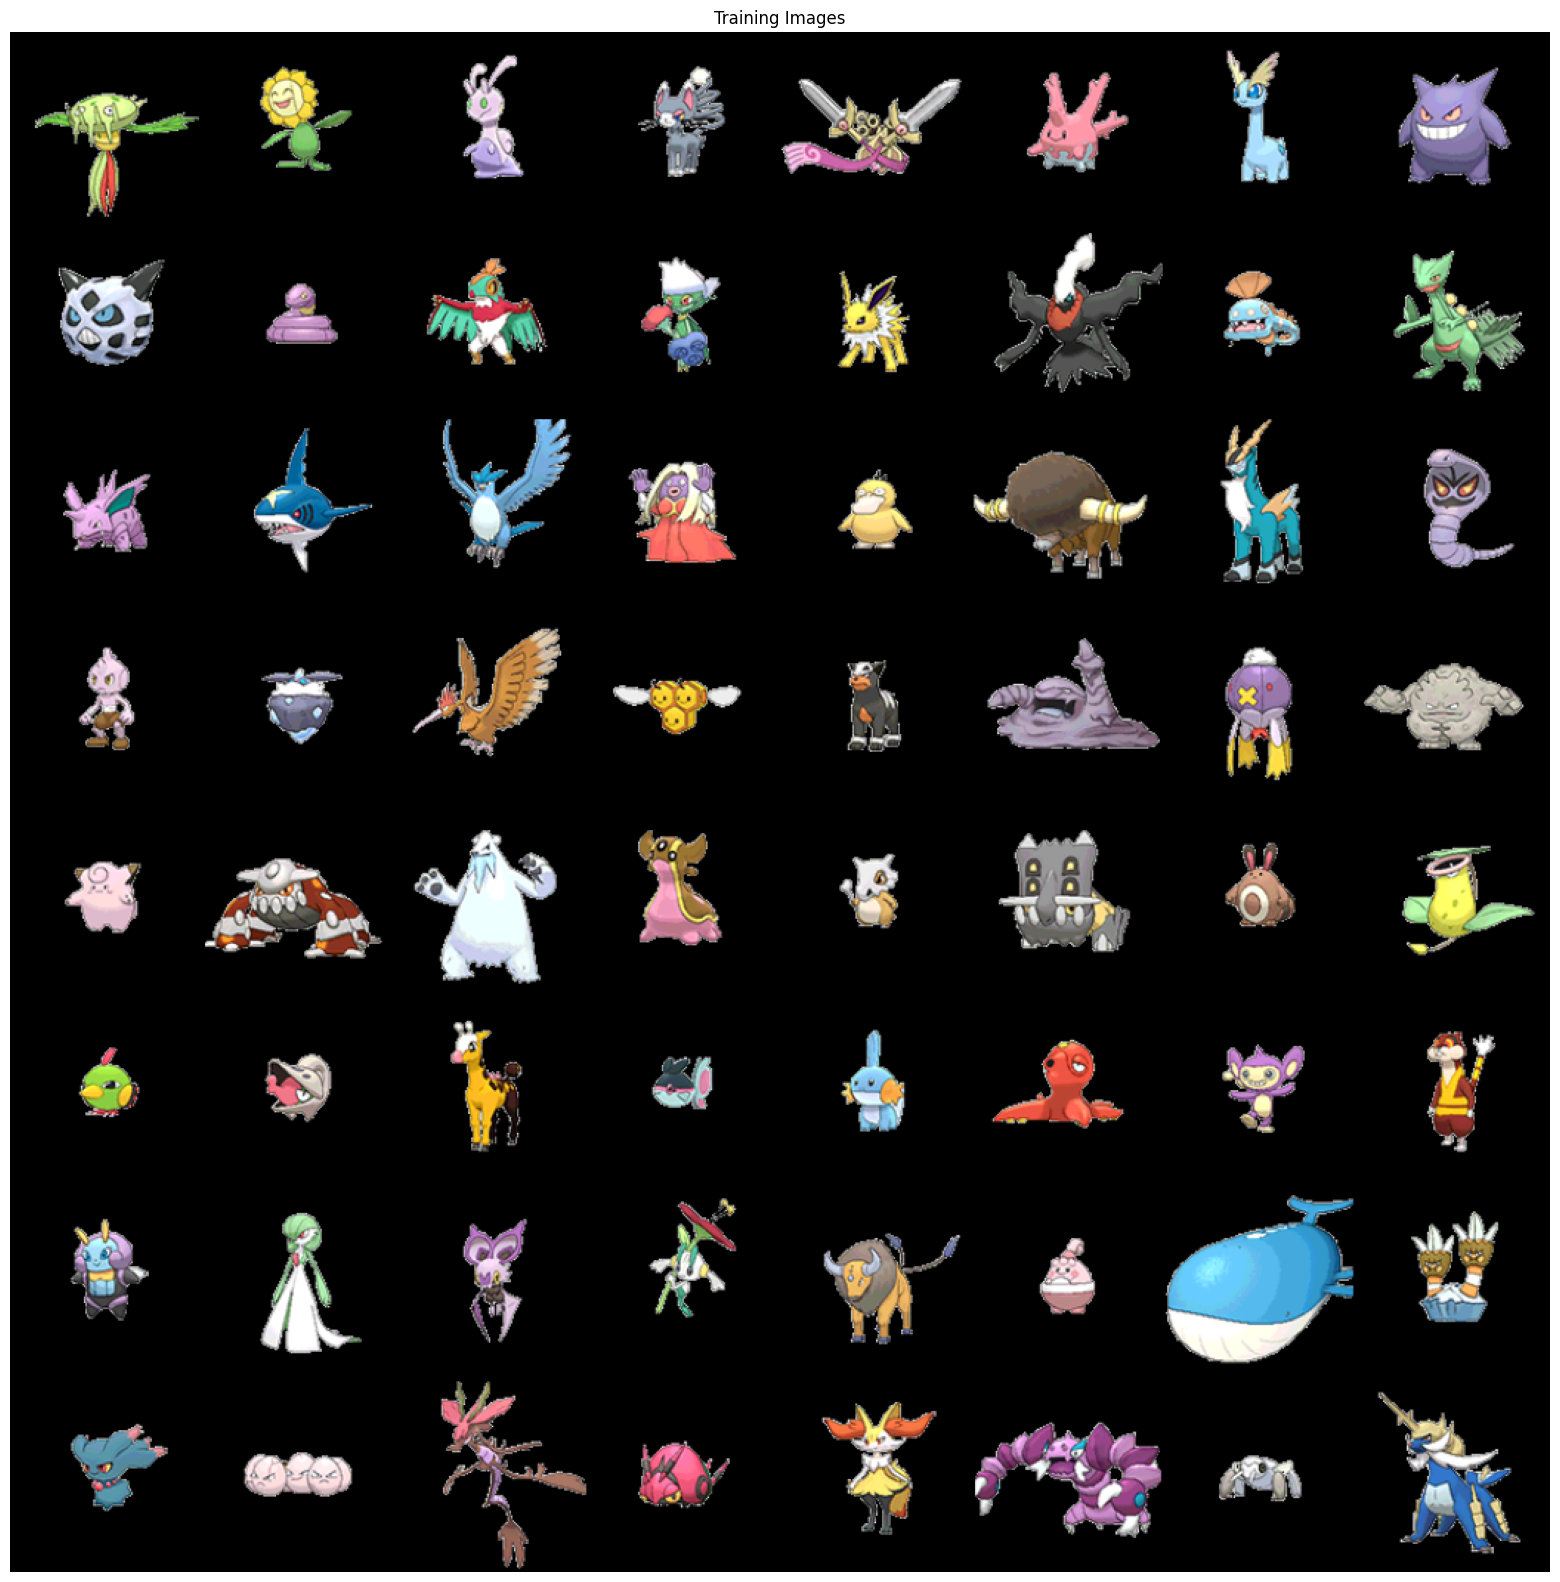

In [4]:
dataset = dset.ImageFolder(root = dataroot, transform = transforms.Compose([transforms.Resize(128),
                                                                           transforms.CenterCrop(128),
                                                                           transforms.ToTensor(),
                                                                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 128, shuffle = True)

# Check the images
real_batch = next(iter(dataloader))
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [5]:
# Weight
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias = False)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias = False)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1, bias = False)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1, bias = False)
        self.conv5 = nn.Conv2d(512, 1024, 4, 2, 1, bias = False)
        self.conv6 = nn.Conv2d(1024, 1, 4, 1, 0, bias = False)
        self.activation = nn.LeakyReLU(0.1, inplace = True)
        self.batch1 = nn.BatchNorm2d(64)
        self.batch2 = nn.BatchNorm2d(128)
        self.batch3 = nn.BatchNorm2d(256)
        self.batch4 = nn.BatchNorm2d(512)
        self.batch5 = nn.BatchNorm2d(1024)
        self.dropout = nn.Dropout(p = 0.35)
    
    def forward(self, x):
        x = self.conv1(x)
        #print(x.size())
        x = self.conv2(x)
        #print(x.size())
        x = self.batch2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.dropout(x)
        #print(x.size())
        x = self.batch3(x)
        x = self.activation(x)
        x = self.conv4(x)
        #print(x.size())
        x = self.batch4(x)
        x = self.activation(x)
        x = self.conv5(x)
        #print(x.size())
        x = self.batch5(x)
        x = self.dropout(x)
        x = self.conv6(x)
        #print(x.size())
        return nn.Sigmoid()(x)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
 
        self.conv1 = nn.ConvTranspose2d(64, 1024, 4, 1, 0, bias = False)
        self.conv2 = nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias = False)
        self.conv3 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False)
        self.conv4 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False)
        self.conv5 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False)
        self.conv6 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False)
        self.activation = nn.ReLU(True)
        self.batch1 = nn.BatchNorm2d(1024)
        self.batch2 = nn.BatchNorm2d(512)
        self.batch3 = nn.BatchNorm2d(256)
        self.batch4 = nn.BatchNorm2d(128)
        self.batch5 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(p = 0.15)
        
    def forward(self, x):
        x = self.conv1(x)
        #print(x.size())
        x = self.batch1(x)
        x = self.activation(x)
        x = self.conv2(x)
        #print(x.size())
        x = self.batch2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv3(x)
        #print(x.size())
        x = self.batch3(x)
        x = self.activation(x)
        x = self.conv4(x)
        x = self.dropout(x)
        #print(x.size())
        x = self.batch4(x)
        x = self.activation(x)
        x = self.conv5(x)
        x = self.dropout(x)
        #print(x.size())
        x = self.batch5(x)
        x = self.activation(x)
        x = self.conv6(x)
        #print(x.size())

        return nn.Tanh()(x)

In [7]:
epoch_num = 1000
lr = 0.00000001
loss = nn.BCELoss()
iteration = 1

discriminator = Discriminator().to(device)
generator = Generator().to(device)

discriminator.apply(weights_init)
generator.apply(weights_init)

d_opt = optim.Adam(discriminator.parameters(), lr = lr, betas=(0.5, 0.999))
g_opt = optim.Adam(generator.parameters(), lr = lr, betas=(0.5, 0.999))

d_loss_values = []
g_loss_values = []
generated_images = []


test_noise = torch.randn(128, 64, 1, 1, device = device)

In [8]:
# Train the generator and discriminator

for epoch in range(epoch_num):
    for idx, (imgs, _) in enumerate(dataloader):
        idx += 1
        iteration += 1
        
        # Update the discriminator
        real_inputs = imgs.to(device)
        #print("real_inputs: ", real_inputs.size())
        real_outputs = discriminator(real_inputs)
        #print("real_outputs: ", real_outputs.size())
        real_label = torch.ones(real_inputs.shape[0]).to(device)    
        #print("real_label: ", real_label.size())
        
        
        noise = (torch.randn(real_inputs.shape[0], 64, 1, 1)).to(device)
        #print("noise: ", noise.size())
        fake_inputs = generator(noise)
        #print("fake_inputs: ", fake_inputs.size())
        fake_outputs = discriminator(fake_inputs)
        #print("fake_outputs: ", fake_outputs.size()) 
        fake_label = torch.zeros(fake_inputs.shape[0]).to(device)
        #print("fake_label: ", fake_label.size())

        d_loss_real = loss(real_outputs.view(-1), real_label)
        d_loss_fake = loss(fake_outputs.view(-1), fake_label)
        d_loss = d_loss_real + d_loss_fake

        d_opt.zero_grad()
        d_loss_real.backward()
        d_loss_fake.backward()
        d_opt.step()

        d_loss_values.append(d_loss.item())

        # Update the generator
        noise = (torch.randn(real_inputs.shape[0], 64, 1, 1)).to(device)
        fake_inputs = generator(noise)
        #print("fake_inputs: ", fake_inputs.size())
        fake_outputs = discriminator(fake_inputs)
        #print("fake_outputs: ", fake_outputs.size())
        fake_label = torch.zeros(fake_inputs.shape[0]).to(device)
        #print("fake_label: ", fake_label.size())

        g_loss = loss(fake_outputs.view(-1), fake_label)
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

        g_loss_values.append(g_loss.item())

        
        if idx % 50 == 0 or idx == len(dataloader):
            print('Epoch {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, d_loss.item(), g_loss.item()))
        
        if iteration % 100 == 0 or (idx == len(dataloader) and epoch == epoch_num - 1):
            with torch.no_grad():
                image = generator(test_noise).detach().cpu()
            generated_images.append(vutils.make_grid(image, padding = 2, normalize = True))

Epoch 0: discriminator_loss 3.236 generator_loss 0.873
Epoch 1: discriminator_loss 3.962 generator_loss 0.842
Epoch 2: discriminator_loss 3.578 generator_loss 1.096
Epoch 3: discriminator_loss 4.284 generator_loss 0.905
Epoch 4: discriminator_loss 3.587 generator_loss 0.890
Epoch 5: discriminator_loss 3.488 generator_loss 1.081
Epoch 6: discriminator_loss 4.027 generator_loss 0.820
Epoch 7: discriminator_loss 3.215 generator_loss 0.867
Epoch 8: discriminator_loss 3.271 generator_loss 1.052
Epoch 9: discriminator_loss 3.211 generator_loss 0.774
Epoch 10: discriminator_loss 3.659 generator_loss 1.052
Epoch 11: discriminator_loss 3.578 generator_loss 0.990
Epoch 12: discriminator_loss 3.394 generator_loss 0.768
Epoch 13: discriminator_loss 3.809 generator_loss 0.902
Epoch 14: discriminator_loss 2.843 generator_loss 1.071
Epoch 15: discriminator_loss 3.580 generator_loss 0.968
Epoch 16: discriminator_loss 3.226 generator_loss 1.066
Epoch 17: discriminator_loss 3.690 generator_loss 1.045
Ep

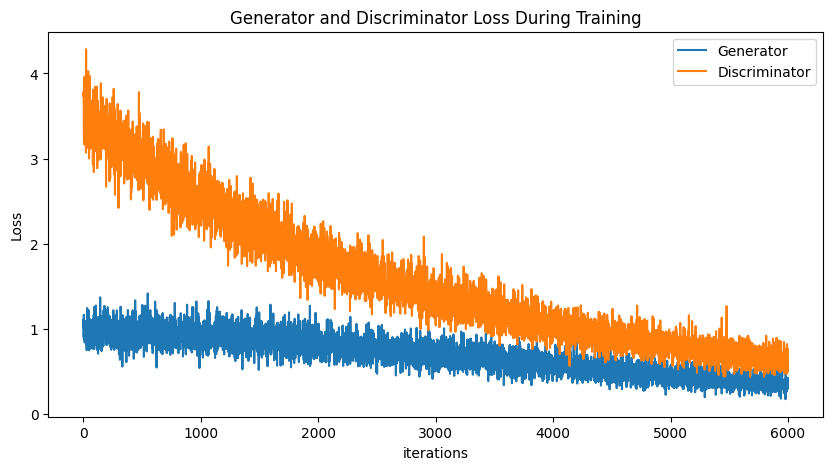

In [9]:
# Plot the loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss_values,label="Generator")
plt.plot(d_loss_values,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

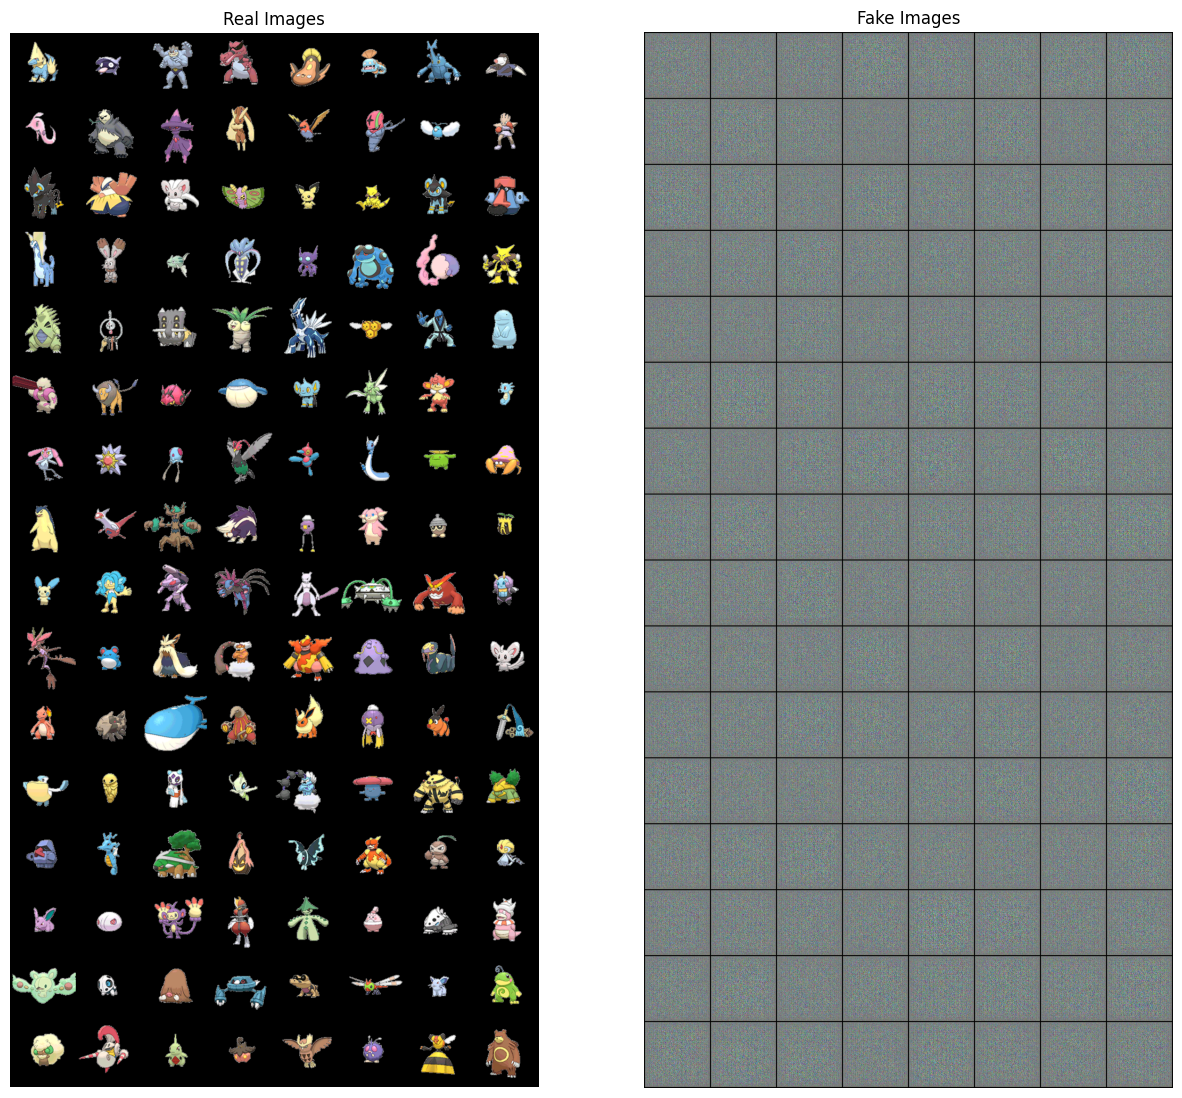

In [11]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(generated_images[-1],(1,2,0)))
plt.show()